In [1]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('cluster_data.csv',encoding = 'utf-8')

In [3]:
df

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,...,신규유입고객,거래지역다양성지수,총거래금액,총거래건수,승인건수점수,승인금액점수,승인점수,고객상태,출장여부,업종_그룹
0,2002967708,202312,202312,1,100.00,5.00,0.00,0,210000.00,5.00,...,1,2,210000,5.0,1,1,2,0,0,생활
1,2004066711,202312,202312,1,100.00,2.50,0.00,0,40000.00,2.50,...,1,1,40000,2.5,1,1,2,0,0,생활
2,2004166649,202312,202312,1,100.00,15.00,0.00,0,220000.00,15.00,...,1,3,220000,15.0,1,1,2,0,1,뷰티/헤어/잡화
3,2004326617,202312,202312,1,100.00,2.50,0.00,0,10000.00,2.50,...,1,1,10000,2.5,1,1,2,0,1,생활
4,2004432929,202312,202312,1,100.00,5.00,0.00,0,460000.00,5.00,...,1,2,460000,5.0,1,1,2,0,1,생활
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
834435,9999918728,202105,202310,30,43.33,4.23,0.57,17,443076.92,4.23,...,1,1,5760000,55.0,1,1,2,0,1,생활
834436,9999933174,202109,202212,16,43.75,9.29,0.56,9,611428.57,9.29,...,1,4,4280000,65.0,2,1,3,0,0,의료/건강
834437,9999972286,202101,202101,1,100.00,2.50,0.00,0,10000.00,2.50,...,0,1,10000,2.5,1,1,2,0,1,생활
834438,9999981183,202101,202211,23,100.00,21.20,0.00,0,371304.35,21.20,...,0,6,8540000,487.5,3,1,4,0,1,음식점


# 1. 데이터 준비 및 전처리

In [4]:
# 2. 라벨 인코딩 ('고객상태'만 Object형)
label_encoder = LabelEncoder()
df['고객상태'] = label_encoder.fit_transform(df['고객상태'])

# 3. 양적/질적 변수 분리
quantitative_features = ['거래활동기간', '거래 연속성 비율', '총거래건수', '총거래금액', '월평균 거래건수']
qualitative_features = ['거래지역다양성지수', '업종다양성지수', '출장여부', '고객상태']

# 4. 변수 가중치 적용
weights = {
    '거래활동기간': 1.5, '거래 연속성 비율': 1.5, '총거래건수': 2.0, '총거래금액': 1.0,
    '월평균 거래건수': 2.0, '거래지역다양성지수': 1.0, '업종다양성지수': 1.2, 
    '출장여부': 1.2, '고객상태': 1.3
}
for col, weight in weights.items():
    df[col] *= weight

# 2. pca차원축소

## 1

In [6]:
# 1. 양적 변수 PCA
pca_quantitative = PCA(n_components=2)
quant_pca = pca_quantitative.fit_transform(df[quantitative_features])

# 2. 질적 변수 PCA
pca_qualitative = PCA(n_components=2)
qual_pca = pca_qualitative.fit_transform(df[qualitative_features])

# 3. 혼합정보 생성
df['혼합정보_1'] = quant_pca[:, 0] + qual_pca[:, 0]
df['혼합정보_2'] = quant_pca[:, 1] + qual_pca[:, 1]

## 2

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1. 양적 변수 스케일링
scaler_quantitative = StandardScaler()
scaled_quantitative = scaler_quantitative.fit_transform(df[quantitative_features])

# 2. 질적 변수 스케일링
scaler_qualitative = StandardScaler()
scaled_qualitative = scaler_qualitative.fit_transform(df[qualitative_features])

# 3. 양적 변수 PCA
pca_quantitative = PCA(n_components=2)
quant_pca = pca_quantitative.fit_transform(scaled_quantitative)

# 4. 질적 변수 PCA
pca_qualitative = PCA(n_components=2)
qual_pca = pca_qualitative.fit_transform(scaled_qualitative)

# 5. 혼합정보 생성
df['혼합정보_1'] = quant_pca[:, 0] + qual_pca[:, 0]
df['혼합정보_2'] = quant_pca[:, 1] + qual_pca[:, 1]

# 3. 군집화 및 업종리스트

In [6]:
# 1. 초기 군집화 (k=30)
kmeans_30 = KMeans(n_clusters=30, random_state=42)
df['군집'] = kmeans_30.fit_predict(df[['혼합정보_1', '혼합정보_2']])

# 2. 각 군집의 상위 10개 업종_그룹 추출
top_n = 10
업종_리스트 = (
    df.groupby('군집')['업종_그룹']
    .apply(lambda x: x.value_counts().head(top_n).index.tolist())
    .reset_index(name='업종_리스트')
)
df = df.merge(업종_리스트, on='군집', how='left')

# 3-1 엘보우그래프

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

# 1. 엘보우 그래프를 위한 군집 수 범위 정의
range_n_clusters = range(2, 31)  # 2부터 30까지 군집 수

# 2. 군집 수별 관성값(WCSS) 계산
inertia = []

for n_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(df[['혼합정보_1', '혼합정보_2']])
    inertia.append(kmeans.inertia_)
    print(f"군집 수 {n_clusters} 완료")

# 3. 엘보우 그래프 그리기
plt.figure(figsize=(10, 6))
plt.plot(range_n_clusters, inertia, marker='o', linestyle='-', color='b')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range_n_clusters)
plt.grid(True)
plt.show()

# 4. 군집 축소 (k=15) 및 자카드 유사도 계산

In [7]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MultiLabelBinarizer

# 1. 군집 축소 (k=15)
kmeans_15 = KMeans(n_clusters=15, random_state=42)
df['최종군집'] = kmeans_15.fit_predict(df[['혼합정보_1', '혼합정보_2']])

# 2. 자카드 유사도 계산 함수
def jaccard_similarity(cluster1, cluster2):
    intersection = len(set(cluster1) & set(cluster2))
    union = len(set(cluster1) | set(cluster2))
    return intersection / union

# 3. 리스트를 바이너리 행렬로 변환 (MultiLabelBinarizer)
mlb = MultiLabelBinarizer()
binarized_terms = mlb.fit_transform(업종_리스트['업종_리스트'])

# 4. 유사도 계산
jaccard_matrix = pairwise_distances(binarized_terms, metric=jaccard_similarity)

# 5. 협업 필터링 및 추천 시스템 구현

In [13]:
from collections import defaultdict

# 1. 각 군집의 상위 10개 업종_그룹 추출 (가산점 부여)
top_n = 10
cluster_recommendations = defaultdict(list)

for cluster_id in df['최종군집'].unique():
    cluster_data = df[df['최종군집'] == cluster_id]
    if '업종_그룹' in df.columns:  # '업종_그룹' 컬럼 존재 여부 확인
        # 업종_그룹의 빈도수 추출
        value_counts = cluster_data['업종_그룹'].value_counts()
        
        # 가산점 부여: 앞에 있을수록 높은 점수 (10점부터 1점까지 부여)
        weighted_scores = {
            index: (rank + 1) * value_counts[index]
            for rank, index in enumerate(value_counts.head(top_n).index)
        }
        
        # 상위 10개 업종_그룹 저장
        sorted_recommendations = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
        cluster_recommendations[cluster_id] = [item[0] for item in sorted_recommendations]
    else:
        raise KeyError("'업종_그룹' 컬럼이 데이터프레임에 없습니다. 확인해 주세요.")

# 2. 추천 시스템 데이터 준비 완료
print("각 군집의 추천 업종_그룹:")
for cluster_id, recommendations in cluster_recommendations.items():
    print(f"군집 {cluster_id}: {recommendations}")

각 군집의 추천 업종_그룹:
군집 2: ['음식점', '기타 서비스업', '생활', '식료품', '주유소', '의료/건강', '스포츠/레저', '보험', '대중교통', '온라인쇼핑']
군집 8: ['음식점', '생활', '의료/건강', '보험', '식료품', '주유소', '온라인쇼핑', '스포츠/레저', '뷰티/헤어/잡화', '교육']
군집 1: ['음식점', '생활', '온라인쇼핑', '의료/건강', '기타 서비스업', '대중교통', '식료품', '주유소', '교육', '스포츠/레저']
군집 12: ['음식점', '생활', '의료/건강', '기타 서비스업', '식료품', '주유소', '온라인쇼핑', '스포츠/레저', '대중교통', '보험']
군집 9: ['음식점', '생활', '온라인쇼핑', '의료/건강', '기타 서비스업', '주유소', '식료품', '교육', '대중교통', '스포츠/레저']
군집 13: ['음식점', '온라인쇼핑', '생활', '기타 서비스업', '의료/건강', '보험', '통신', '식료품', '주유소', '교육']
군집 5: ['생활', '온라인쇼핑', '음식점', '의료/건강', '기타 서비스업', '식료품', '보험', '통신', '대중교통', '주유소']
군집 0: ['온라인쇼핑', '음식점', '생활', '의료/건강', '식료품', '스포츠/레저', '통신', '보험', '대중교통', '주유소']
군집 11: ['생활', '온라인쇼핑', '음식점', '의료/건강', '식료품', '통신', '기타 서비스업', '보험', '주유소', '대중교통']
군집 6: ['기타 서비스업', '생활', '온라인쇼핑', '음식점', '보험', '의료/건강', '대중교통', '주유소', '식료품', '통신']
군집 7: ['음식점', '생활', '온라인쇼핑', '의료/건강', '식료품', '대중교통', '보험', '스포츠/레저', '통신', '주유소']
군집 4: ['기타 서비스업', '생활', '음식점', '보험', '온라인쇼핑', '의료/건강'

In [ ]:
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

# 1. 각 군집의 상위 10개 업종_그룹 추출 (기존 로직 유지)
top_n = 10
cluster_recommendations = defaultdict(list)

for cluster_id in df['최종군집'].unique():
    cluster_data = df[df['최종군집'] == cluster_id]
    if '업종_그룹' in df.columns:
        value_counts = cluster_data['업종_그룹'].value_counts()
        weighted_scores = {
            index: (rank + 1) * value_counts[index]
            for rank, index in enumerate(value_counts.head(top_n).index)
        }
        sorted_recommendations = sorted(weighted_scores.items(), key=lambda x: x[1], reverse=True)
        cluster_recommendations[cluster_id] = [item[0] for item in sorted_recommendations]
    else:
        raise KeyError("'업종_그룹' 컬럼이 데이터프레임에 없습니다. 확인해 주세요.")

# 2. 콘텐츠 기반 추천 (동적 유사도 계산)
def generate_recommendations_dynamic(df, target_customer_idx, cluster_recommendations, features, top_n=10):
    """군집 기반 추천과 콘텐츠 기반 추천 혼합 (유사도 동적 계산)"""
    # 대상 고객의 정보
    target_vector = df.iloc[target_customer_idx][features].values.reshape(1, -1)
    customer_cluster = df.iloc[target_customer_idx]['최종군집']
    cluster_items = cluster_recommendations.get(customer_cluster, [])

    # 동적 유사도 계산: 대상 고객과 다른 고객 간 유사도 계산
    all_vectors = df[features].values
    similarities = cosine_similarity(target_vector, all_vectors)[0]
    similar_indices = similarities.argsort()[::-1][:top_n]
    similar_customers = df.iloc[similar_indices]

    # 콘텐츠 기반 추천
    content_items = similar_customers['업종_그룹'].value_counts().index[:top_n].tolist()

    # 혼합 추천
    combined_items = list(set(cluster_items + content_items))[:top_n]
    return combined_items

# 3. 추천 시스템 실행
recommendations_per_customer = defaultdict(list)

print("추천 시스템 실행 시작...")
for idx, customer in enumerate(df['고객ID']):
    if idx % 100 == 0:
        print(f"현재 처리 중인 고객 인덱스: {idx}/{len(df)}")
    recommendations_per_customer[customer] = generate_recommendations_dynamic(
        df,
        target_customer_idx=idx,
        cluster_recommendations=cluster_recommendations,
        features=['혼합정보_1', '혼합정보_2'],
        top_n=10
    )
print("추천 시스템 실행 완료.")

추천 시스템 실행 시작...
현재 처리 중인 고객 인덱스: 0/834440
현재 처리 중인 고객 인덱스: 100/834440
현재 처리 중인 고객 인덱스: 200/834440
현재 처리 중인 고객 인덱스: 300/834440
현재 처리 중인 고객 인덱스: 400/834440
현재 처리 중인 고객 인덱스: 500/834440
현재 처리 중인 고객 인덱스: 600/834440
현재 처리 중인 고객 인덱스: 700/834440
현재 처리 중인 고객 인덱스: 800/834440
현재 처리 중인 고객 인덱스: 900/834440
현재 처리 중인 고객 인덱스: 1000/834440
현재 처리 중인 고객 인덱스: 1100/834440
현재 처리 중인 고객 인덱스: 1200/834440
현재 처리 중인 고객 인덱스: 1300/834440
현재 처리 중인 고객 인덱스: 1400/834440
현재 처리 중인 고객 인덱스: 1500/834440
현재 처리 중인 고객 인덱스: 1600/834440
현재 처리 중인 고객 인덱스: 1700/834440
현재 처리 중인 고객 인덱스: 1800/834440
현재 처리 중인 고객 인덱스: 1900/834440
현재 처리 중인 고객 인덱스: 2000/834440
현재 처리 중인 고객 인덱스: 2100/834440
현재 처리 중인 고객 인덱스: 2200/834440
현재 처리 중인 고객 인덱스: 2300/834440
현재 처리 중인 고객 인덱스: 2400/834440
현재 처리 중인 고객 인덱스: 2500/834440
현재 처리 중인 고객 인덱스: 2600/834440
현재 처리 중인 고객 인덱스: 2700/834440
현재 처리 중인 고객 인덱스: 2800/834440
현재 처리 중인 고객 인덱스: 2900/834440
현재 처리 중인 고객 인덱스: 3000/834440
현재 처리 중인 고객 인덱스: 3100/834440
현재 처리 중인 고객 인덱스: 3200/834440
현재 처리 중인 고객 인덱스: 3300/834440
현재 처리 중인 고

# 6. 외부데이터셋에 추천시스템 적용

In [15]:
# 1. 외부데이터셋 로드
external_df = pd.read_csv("외부데이터.csv")  # '외부데이터셋' 로드

# 2. 컬럼명 매핑 (df데이터셋 -> 외부데이터셋)
# 기존 'df데이터셋'의 주요 컬럼과 '외부데이터셋' 컬럼 간 매핑
column_mapping = {
    '고객ID': '발급회원번호',
    '업종_그룹': '최상위카드등급코드',  # 유사한 '업종' 개념 사용
    '최종군집': '군집'  # 새로 생성할 군집 컬럼
}

# 외부데이터셋에 매핑 적용
external_df = external_df.rename(columns=column_mapping)

# 3. 혼합정보 생성 (예제: 가중치 적용)
weights = {'청구금액_R3M': 1.5, '이용금액_R3M_신용': 1.2}  # 예제 가중치
for col, weight in weights.items():
    if col in external_df.columns:
        external_df[col] *= weight

external_df['혼합정보_1'] = external_df[['청구금액_R3M', '이용금액_R3M_신용']].sum(axis=1)  # 예제 계산
external_df['혼합정보_2'] = external_df[['청구금액_R3M', '이용금액_R3M_신용']].mean(axis=1)  # 예제 계산

# 4. 필요 데이터 준비
if '군집' not in external_df.columns:  # 군집 컬럼이 없는 경우
    # 기존 추천시스템의 kmeans 모델 활용
    external_df['군집'] = kmeans_15.predict(external_df[['혼합정보_1', '혼합정보_2']])

# 5. 외부데이터셋에 추천 시스템 적용
external_df['추천_업종_리스트'] = external_df['군집'].map(cluster_recommendations)

# 6. 결과 확인
print("외부데이터셋에 추천 업종 리스트 적용 결과:")
print(external_df[['발급회원번호', '추천_업종_리스트']].head())

외부데이터셋에 추천 업종 리스트 적용 결과:
  발급회원번호                                          추천_업종_리스트
0  SYN_0  [음식점, 온라인쇼핑, 생활, 자동차/공구, 의료/건강, 기타, 주유소, 식료품, ...
1  SYN_1  [음식점, 온라인쇼핑, 생활, 자동차/공구, 의료/건강, 기타, 주유소, 식료품, ...
2  SYN_2  [음식점, 온라인쇼핑, 생활, 자동차/공구, 의료/건강, 기타, 주유소, 식료품, ...
3  SYN_3  [음식점, 온라인쇼핑, 생활, 자동차/공구, 의료/건강, 기타, 주유소, 식료품, ...
4  SYN_4  [음식점, 온라인쇼핑, 생활, 기타 서비스업, 의료/건강, 보험, 통신, 식료품, ...


In [ ]:
# 외부 데이터셋에 추천 시스템 적용
external_df['추천_업종_리스트'] = external_df['군집'].map(cluster_recommendations)

# 콘텐츠 기반 추천 추가 (외부 데이터셋)
def apply_content_recommendation(external_df, cluster_recommendations, features, top_n=10):
    """외부 데이터셋에도 콘텐츠 기반 추천 혼합"""
    recommendations_per_customer = []
    for index, row in external_df.iterrows():
        customer_id = row['발급회원번호']
        customer_cluster = row['군집']
        
        # 군집 기반 추천
        cluster_items = cluster_recommendations.get(customer_cluster, [])
        
        # 콘텐츠 기반 추천
        customer_features = row[features].values.reshape(1, -1)
        similarities = cosine_similarity(customer_features, external_df[features].values)
        similar_customers = external_df.assign(similarity=similarities[0]).sort_values('similarity', ascending=False)
        content_items = similar_customers['추천_업종_리스트'].explode().value_counts().index[:top_n].tolist()

        # 혼합 추천
        combined_items = list(set(cluster_items + content_items))[:top_n]
        recommendations_per_customer.append(combined_items)

    external_df['최종_추천_리스트'] = recommendations_per_customer
    return external_df

# 추천 시스템 적용
# 참고된 필드명: '청구금액_R3M', '이용금액_R3M_신용', 'Life_Stage'
features = ['청구금액_R3M', '이용금액_R3M_신용', 'Life_Stage']  # 외부 데이터셋의 고객 특성
external_df = apply_content_recommendation(external_df, cluster_recommendations, features, top_n=10)

# 결과 출력
print("외부 데이터셋에 추천 시스템 적용 결과:")
print(external_df[['발급회원번호', '최종_추천_리스트']].head(10))

# 7. 추천시스템 평가

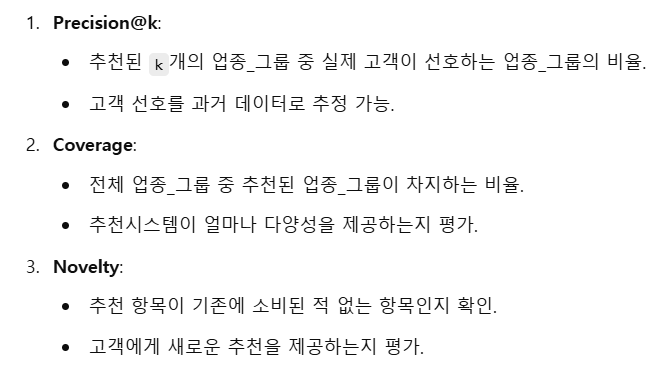\
**2,3만진행**

In [16]:
# 1. Coverage 계산
def coverage(recommendations, all_items):
    recommended_items = set(item for rec in recommendations for item in rec)
    return len(recommended_items) / len(all_items)

# 2. Novelty 계산
def novelty(recommendations, customer_history):
    novelty_scores = []
    for rec, hist in zip(recommendations, customer_history):
        novel_items = set(rec) - set(hist)
        novelty_scores.append(len(novel_items) / len(rec) if len(rec) > 0 else 0)
    return sum(novelty_scores) / len(novelty_scores)

# 3. 평가 진행
# 고객별 추천 리스트 (결측값을 빈 리스트로 처리)
recommendations = external_df['추천_업종_리스트'].apply(lambda x: x if isinstance(x, list) else []).tolist()

# 전체 업종_그룹
all_items = set(item for sublist in cluster_recommendations.values() for item in sublist)  # 모든 업종 리스트

# 고객별 과거 소비 이력 (외부데이터셋에는 없음 -> 기본적으로 빈 리스트로 설정)
customer_history = [[] for _ in range(len(external_df))]  # 외부데이터는 과거 이력 없음

# Coverage
coverage_score = coverage(recommendations, all_items)

# Novelty
novelty_score = novelty(recommendations, customer_history)

# 결과 출력
print(f"Coverage: {coverage_score:.2f}")
print(f"Novelty: {novelty_score:.2f}")

Coverage: 1.00
Novelty: 1.00
